<a href="https://colab.research.google.com/github/thomasjuin1/EmotionClassification/blob/twitter-dataset/LSTM_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN (LSTM cell) for emotion recognition
In this python notebook we will see how to classify the emotion of a text using a RecurentNeuralNetwork.
We will work on the [emotion](https://huggingface.co/datasets/dair-ai/emotion/viewer/unsplit) dataset.



In [24]:
!pip install datasets

In [25]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

In [26]:
# Specify the subset to use split = 20k rows already separated, UNSPLIT 400k rows not separated
SUBSET = "split"
# SUBSET = "unsplit"

ds = load_dataset("dair-ai/emotion", SUBSET)

# Get the train, validation and test sets
train_set, val_set, test_set = None, None, None

if SUBSET == "split":
    train_set = ds["train"]
    test_set = ds["test"]
    val_set = ds["validation"]
else:
    # Split the training, validation and test sets
    def split_dataset(dataset, train_ratio: float = 0.7,
                      test_ratio: float = 0.1,
                      val_ratio: float = 0.1):
        length = len(ds["train"])
        train_set = ds["train"].select(range(int(length * 0.8)))
        test_set = ds["train"].select(range(int(length * 0.1), int(length * (train_ratio + test_ratio))))
        val_set = ds["train"].select(range(int(length * (train_ratio + test_ratio)), length))
        return train_set, test_set, val_set

    train_set, test_set, val_set = split_dataset(ds["train"], 0.8, 0.1, 0.1)

# Make sure the dataset is in the right format and in memory
train_set = train_set.map(lambda x: {"text": x["text"], "label": x["label"]})
test_set = test_set.map(lambda x: {"text": x["text"], "label": x["label"]})
val_set = val_set.map(lambda x: {"text": x["text"], "label": x["label"]})

Those list and dict will be used later in the program for translation.

In [27]:
__emotions = [
    "sadness",
    "joy",
    "love",
    "anger",
    "fear",
    "surprise",
]

EMOTION_TO_INDEX = {
    emotion: index for index, emotion in enumerate(__emotions)
}

INDEX_TO_EMOTION = {
    index: emotion for emotion, index in EMOTION_TO_INDEX.items()
}

## Pre-process the dataset
Before using the dataset, we need to pre-process it.

We will:

Remove the stopwords
Remove the punctuation
Lemmatize the text
Convert the text to lowercase
We will pre-process the training dataset, for it to be ready to train on.
The encode function ensure a sequence of fix size (usefule for a lot of things batch for eg.)

In [28]:
import spacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")

def preprocess(text: str) -> list[str]:
    """
    This function remove stop word, lemmatize the token of the text, lowercase it

    Args:
      text: The text to preprocess

    Returns:
      A tokenize version of the text
    """
    tokens = nlp(text)
    return [token.lemma_.lower().strip() for token in tokens if not token.is_stop]

def build_vocab(texts: list[str], max_vocab_size: int) -> dict[str, int]:
    """
    Builds a vocabulary mapping tokens to unique indices from a list of texts.
    - The vocabulary is constructed based on token frequency, keeping the most common tokens
      up to the specified `max_vocab_size`.
    - Tokens beyond `max_vocab_size` are excluded from the vocabulary.

    Args:
        texts (list[str]): A list of input texts to be tokenized and processed.
        max_vocab_size (int): The maximum size of the vocabulary, including special tokens.

    Returns:
        dict[str, int]: A dictionary where:
            - Keys are tokens (words).
            - Values are unique integer indices.
            Special tokens included:
            - "<PAD>": 0 (used for padding).
            - "<UNK>": 1 (used for unknown tokens).
            Other tokens are assigned indices starting from 2.


    """
    counter = Counter(token for text in texts for token in preprocess(text))
    most_common: list[tuple[str, int]] = counter.most_common(max_vocab_size - 2)
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(most_common)}  # Reserve 0 and 1
    vocab["<PAD>"] = 0
    vocab["<UNK>"] = 1
    return vocab

def encode(text: str, vocab: dict[str, int], max_len: int) -> list[int]:
    """
    Encodes a text into a fixed-length sequence of token IDs using a given vocabulary.

    Args:
        text: The input text to be tokenized and encoded.
        vocab (dict[str, int: A dictionary mapping tokens to their corresponding IDs.
            Special tokens:
            - "<PAD>": ID used for padding.
            - "<UNK>": ID used for unknown tokens.
        max_len (int): The maximum length of the encoded sequence. Longer sequences are truncated,
            and shorter sequences are padded.

    Returns:
        list[int]: A list of token IDs representing the encoded text, with a fixed length of `max_len`.
    """

    tokens = preprocess(text)
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    if len(ids) > max_len:
        return ids[:max_len]
    return ids + [vocab["<PAD>"]] * (max_len - len(ids))

# Build vocabulary
all_texts = train_set["text"]
VOCAB_SIZE = 10000
MAX_LEN = 50
vocab = build_vocab(all_texts, VOCAB_SIZE)

We create a Dataset class that inherit from pytorch Dataset object, to use Dataloader

In [29]:
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        input_ids = torch.tensor(encode(text, self.vocab, self.max_len), dtype=torch.long)
        return {
            "input_ids": input_ids,
            "labels": torch.tensor(label, dtype=torch.long),
        }
# Prepare datasets
train_dataset = EmotionDataset(train_set["text"], train_set["label"], vocab, MAX_LEN)
val_dataset = EmotionDataset(val_set["text"], val_set["label"], vocab, MAX_LEN)
test_dataset = EmotionDataset(test_set["text"], test_set["label"], vocab, MAX_LEN)

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

NUM_CLASSES = len(set(train_set["label"]))  # Number of unique emotions

## Create the LSTM model
In the next cell create we our model

With 4 layer: (5 if we count dropout)
- embedings (batch_size, seq_length)
- LSTM (batch_size, seq_length, embed_dim)
- Mean Pooling (batch_size, seq_length, hidden_dim)
- fully conected (batch_size, hidden_dim) -> (batch_size, NUM_CLASSES)

In [30]:
class LSTM(nn.Module):
    def __init__(self, embed_dim: int, dropout_p: float = 0.1):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, embed_dim)
        self.lstm = nn.LSTM(embed_dim, embed_dim, batch_first=True)
        self.fc = nn.Linear(embed_dim, NUM_CLASSES)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        output, (h_n, c_n) = self.lstm(embedded)

        avg_hidden = output.mean(dim=1)

        logits = self.fc(avg_hidden)
        return logits
use_gpu = torch.cuda.is_available()
DEVICE = 'cuda' if use_gpu else 'cpu'
print(f"Using : {DEVICE}")

model = LSTM(embed_dim=128, dropout_p=0.2)
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using : cuda


## Training
In this cell we train our model and we can evaluate
along the training to see if our model is doing good
(This task can be long 20min on T4 GPU for split dataset)

In [31]:
def train_model(model,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                epochs,
                doEvaluate) -> None:
    """
    This function tain the model and validat along the way if the parameter doEvaluate is true
    """
    print("Training the model")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation
        if doEvaluate:
          model.eval()
          val_loss = 0
          val_preds, val_labels = [], []
          with torch.no_grad():
              print ("Validating the model")
              for batch in val_loader:
                  input_ids = batch["input_ids"].to(DEVICE)
                  labels = batch["labels"].to(DEVICE)

                  outputs = model(input_ids)
                  loss = criterion(outputs, labels)
                  val_loss += loss.item()

                  preds = torch.argmax(outputs, dim=1).cpu().numpy()
                  val_preds.extend(preds)
                  val_labels.extend(labels.cpu().numpy())

          print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
        else:
          print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, 10, True)

Training the model
Validating the model
Epoch 1: Train Loss = 726.4045, Val Loss = 63.9662
Validating the model
Epoch 2: Train Loss = 370.2510, Val Loss = 30.1898
Validating the model
Epoch 3: Train Loss = 206.3379, Val Loss = 22.0356
Validating the model
Epoch 4: Train Loss = 136.3894, Val Loss = 18.3775
Validating the model
Epoch 5: Train Loss = 105.1711, Val Loss = 16.1715
Validating the model
Epoch 6: Train Loss = 83.7449, Val Loss = 15.6771
Validating the model
Epoch 7: Train Loss = 66.2400, Val Loss = 14.7689
Validating the model
Epoch 8: Train Loss = 56.0317, Val Loss = 15.6991
Validating the model
Epoch 9: Train Loss = 48.6137, Val Loss = 16.2606
Validating the model
Epoch 10: Train Loss = 40.1749, Val Loss = 16.3353


## Evaluation Time
In the two next celle we are gonna evaluate the model with two differnet graphics

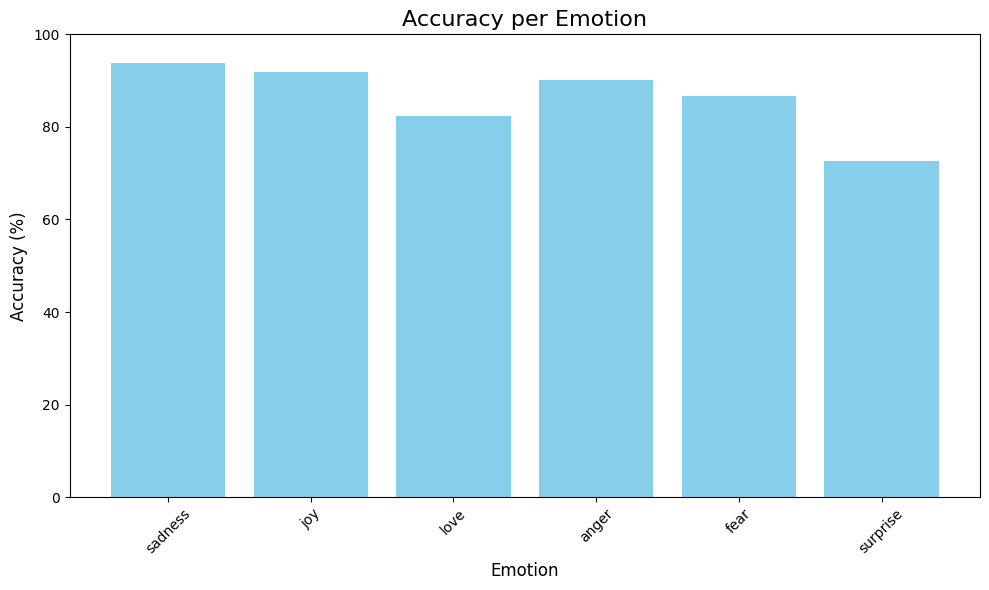

Overall Accuracy: 90.25%
Accuracy per emotion:
sadness: 93.80%
joy: 91.94%
love: 82.39%
anger: 90.18%
fear: 86.61%
surprise: 72.73%


In [32]:
from collections import defaultdict
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, index_to_emotion, device):
    """
    Evaluate the model and compute accuracy per emotion.

    Args:
        model: The trained model.
        data_loader: DataLoader for the evaluation set.
        index_to_emotion: A dictionary mapping label indices to emotion names.
        device: The device to run the evaluation on.

    Returns:
        A dictionary with emotion-wise accuracy and a plot.
    """
    model.eval()
    emotion_correct = defaultdict(int)
    emotion_total = defaultdict(int)
    total_correct = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            labels = labels.cpu().numpy()

            # Update overall accuracy counts
            total_correct += (preds == labels).sum()
            total_predictions += len(labels)

            # Update emotion-specific counts
            for true_label, pred_label in zip(labels, preds):
                true_emotion = index_to_emotion[true_label]
                predicted_emotion = index_to_emotion[pred_label]
                emotion_total[true_emotion] += 1
                if true_emotion == predicted_emotion:
                    emotion_correct[true_emotion] += 1

    # Calculate overall accuracy manually
    overall_accuracy = (total_correct / total_predictions) * 100 if total_predictions > 0 else 0

    # Calculate accuracy per emotion
    emotion_accuracy = {
        emotion: (emotion_correct[emotion] / emotion_total[emotion] * 100)
        if emotion_total[emotion] > 0 else 0
        for emotion in index_to_emotion.values()
    }

    # Plot accuracy per emotion
    plt.figure(figsize=(10, 6))
    plt.bar(emotion_accuracy.keys(), emotion_accuracy.values(), color="skyblue")
    plt.title("Accuracy per Emotion", fontsize=16)
    plt.xlabel("Emotion", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    # Print the results
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print("Accuracy per emotion:")
    for emotion, accuracy in emotion_accuracy.items():
        print(f"{emotion}: {accuracy:.2f}%")

    return emotion_accuracy


# Evaluate the trained model
emotion_accuracy = evaluate_model(
    model=model,
    data_loader=test_loader,
    index_to_emotion=INDEX_TO_EMOTION,
    device=DEVICE
)

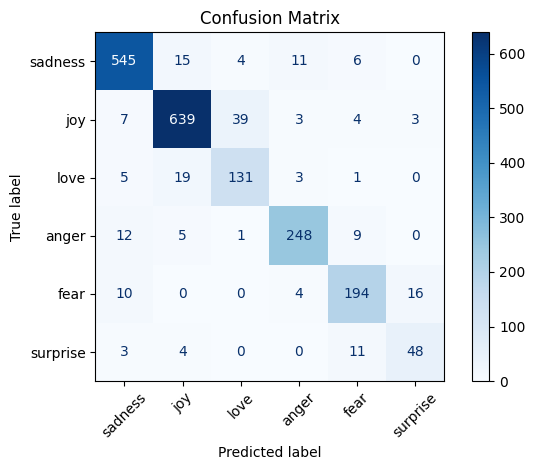

In [33]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming 'model', 'test_loader', 'DEVICE', and 'INDEX_TO_EMOTION' are defined
true_labels = [data['labels'].item() for data in test_loader.dataset]
predicted_labels = [
    model(data["input_ids"].unsqueeze(0).to(DEVICE)).argmax(dim=1).item()
    for data in test_loader.dataset
]

# Generate and plot confusion matrix
ConfusionMatrixDisplay.from_predictions(
    true_labels, predicted_labels, display_labels=list(INDEX_TO_EMOTION.values()),
    cmap='Blues', xticks_rotation=45
)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
